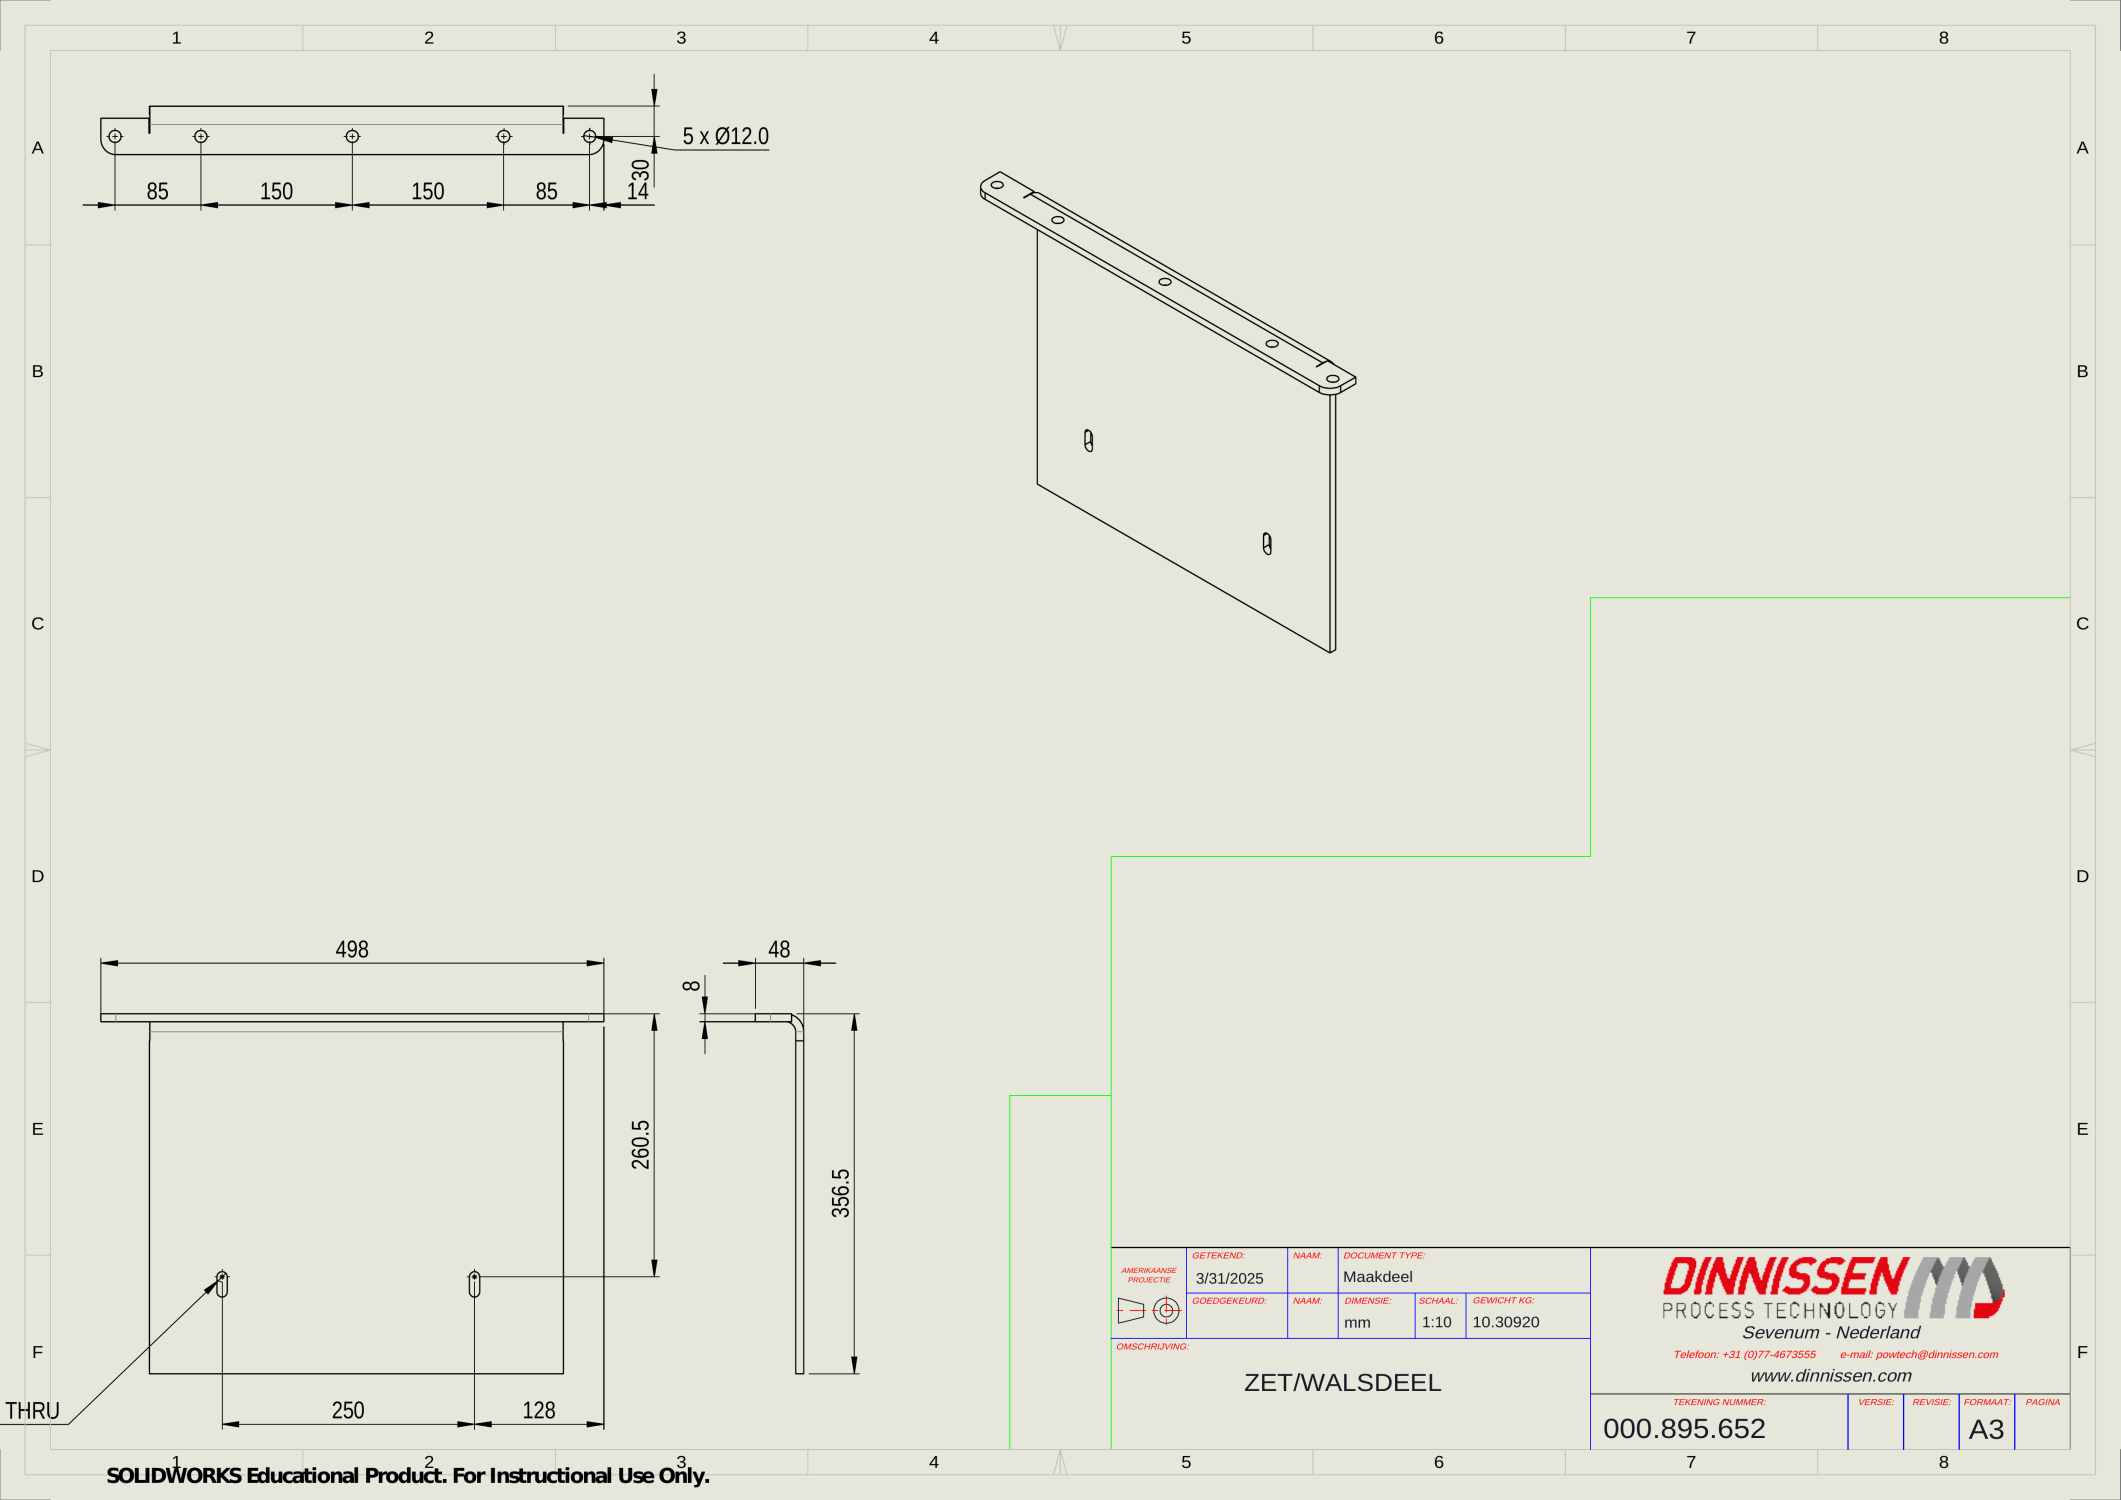

In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Good/300-014823.pdf"
# f = "../../data/original/Good/300-014822.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

Image.fromarray(img_comp)

In [2]:
def detect_intersection_with_borders(img, boundary, title_boundary):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(
        edges,
        rho=1,
        theta=np.pi / 180,
        threshold=100,
        minLineLength=50,
        maxLineGap=10
    )
    lines = remove_similar_lines(lines)

    tolerance = 10
    (x1, y1), (x2, y2) = boundary.copy()
    y2 += tolerance
    y1 -= tolerance
    x2 -= tolerance
    x1 += tolerance

    boundary_lines = [
        [x1, y2, x2, y2],  # Top
        [x1, y1, x2, y1],  # Bottom
        [x2, y2, x2, y1],  # Right
        [x1, y2, x1, y1],  # Left
    ]
    drawings = lines.copy()
    (x1, y1), (x2, y2) = boundary
    left = min(x1, x2)
    right = max(x1, x2)
    top = min(y1, y2)
    bottom = max(y1, y2)

    drawings = drawings[
        ~((drawings[:, 1] <= top + 1) & (drawings[:, 3] <= top + 1))
        & ~((drawings[:, 1] >= bottom - 1) & (drawings[:, 3] >= bottom - 1))
        & ~((drawings[:, 0] <= left + 1) & (drawings[:, 2] <= left + 1))
        & ~((drawings[:, 0] > right) & (drawings[:, 2] > right))
    ]
    lines = drawings.copy()
    drawings = lines.copy()
    (x1, y1), (x2, y2) = title_boundary
    left = min(x1, x2)
    top = min(y1, y2)

    drawings = drawings[
        ~((drawings[:, 1] >= top + 1) & (drawings[:, 3] >= top + 1) & (drawings[:, 0] >= left - 1) & (drawings[:, 2] >= left - 1))
    ]
    lines = drawings.copy()

    intersected_lines = []
    top_intersected = find_intersected_lines(boundary_lines[0], lines)
    top_intersected = lines[top_intersected]
    intersected_lines.extend(top_intersected)

    bottom_intersected = find_intersected_lines(boundary_lines[1], lines)
    bottom_intersected = lines[bottom_intersected]
    intersected_lines.extend(bottom_intersected)

    right_intersected = find_intersected_lines(boundary_lines[2], lines)
    right_intersected = lines[right_intersected]
    intersected_lines.extend(right_intersected)

    left_intersected = find_intersected_lines(boundary_lines[3], lines)
    left_intersected = lines[left_intersected]
    intersected_lines.extend(left_intersected)

    intersected_lines = np.array(intersected_lines)
    connected_lines = []
    for intersected_line in intersected_lines:
        x1, y1, x2, y2 = intersected_line
        connected = find_connected_lines_recursive([x1, y1, x2, y2], lines)
        connected_lines.extend(connected)

    return lines[list(set(connected_lines))]

In [3]:
im_h, im_w, _ = img.shape
sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)
contours = detect_text_tables(img, words, mask)
title_contours = title_contours + contours

boundary = get_boundary(border_1, border_2, inner_border_lines)
title_boundary = get_title_boundary(boundary, line_90, title_contours, words, im_h)

intersected_extended_lines = detect_intersection_with_borders(img.copy(), boundary, title_boundary)
intersected_extended_lines

array([[1110, 1449, 1110,  855],
       [1111,  855, 1591,  855],
       [1591,  854, 1591,  596],
       [   0, 1425,   68, 1425],
       [1589,  598, 2070,  598],
       [  70, 1424,  198, 1300],
       [1010, 1449, 1010, 1094]], dtype=int32)

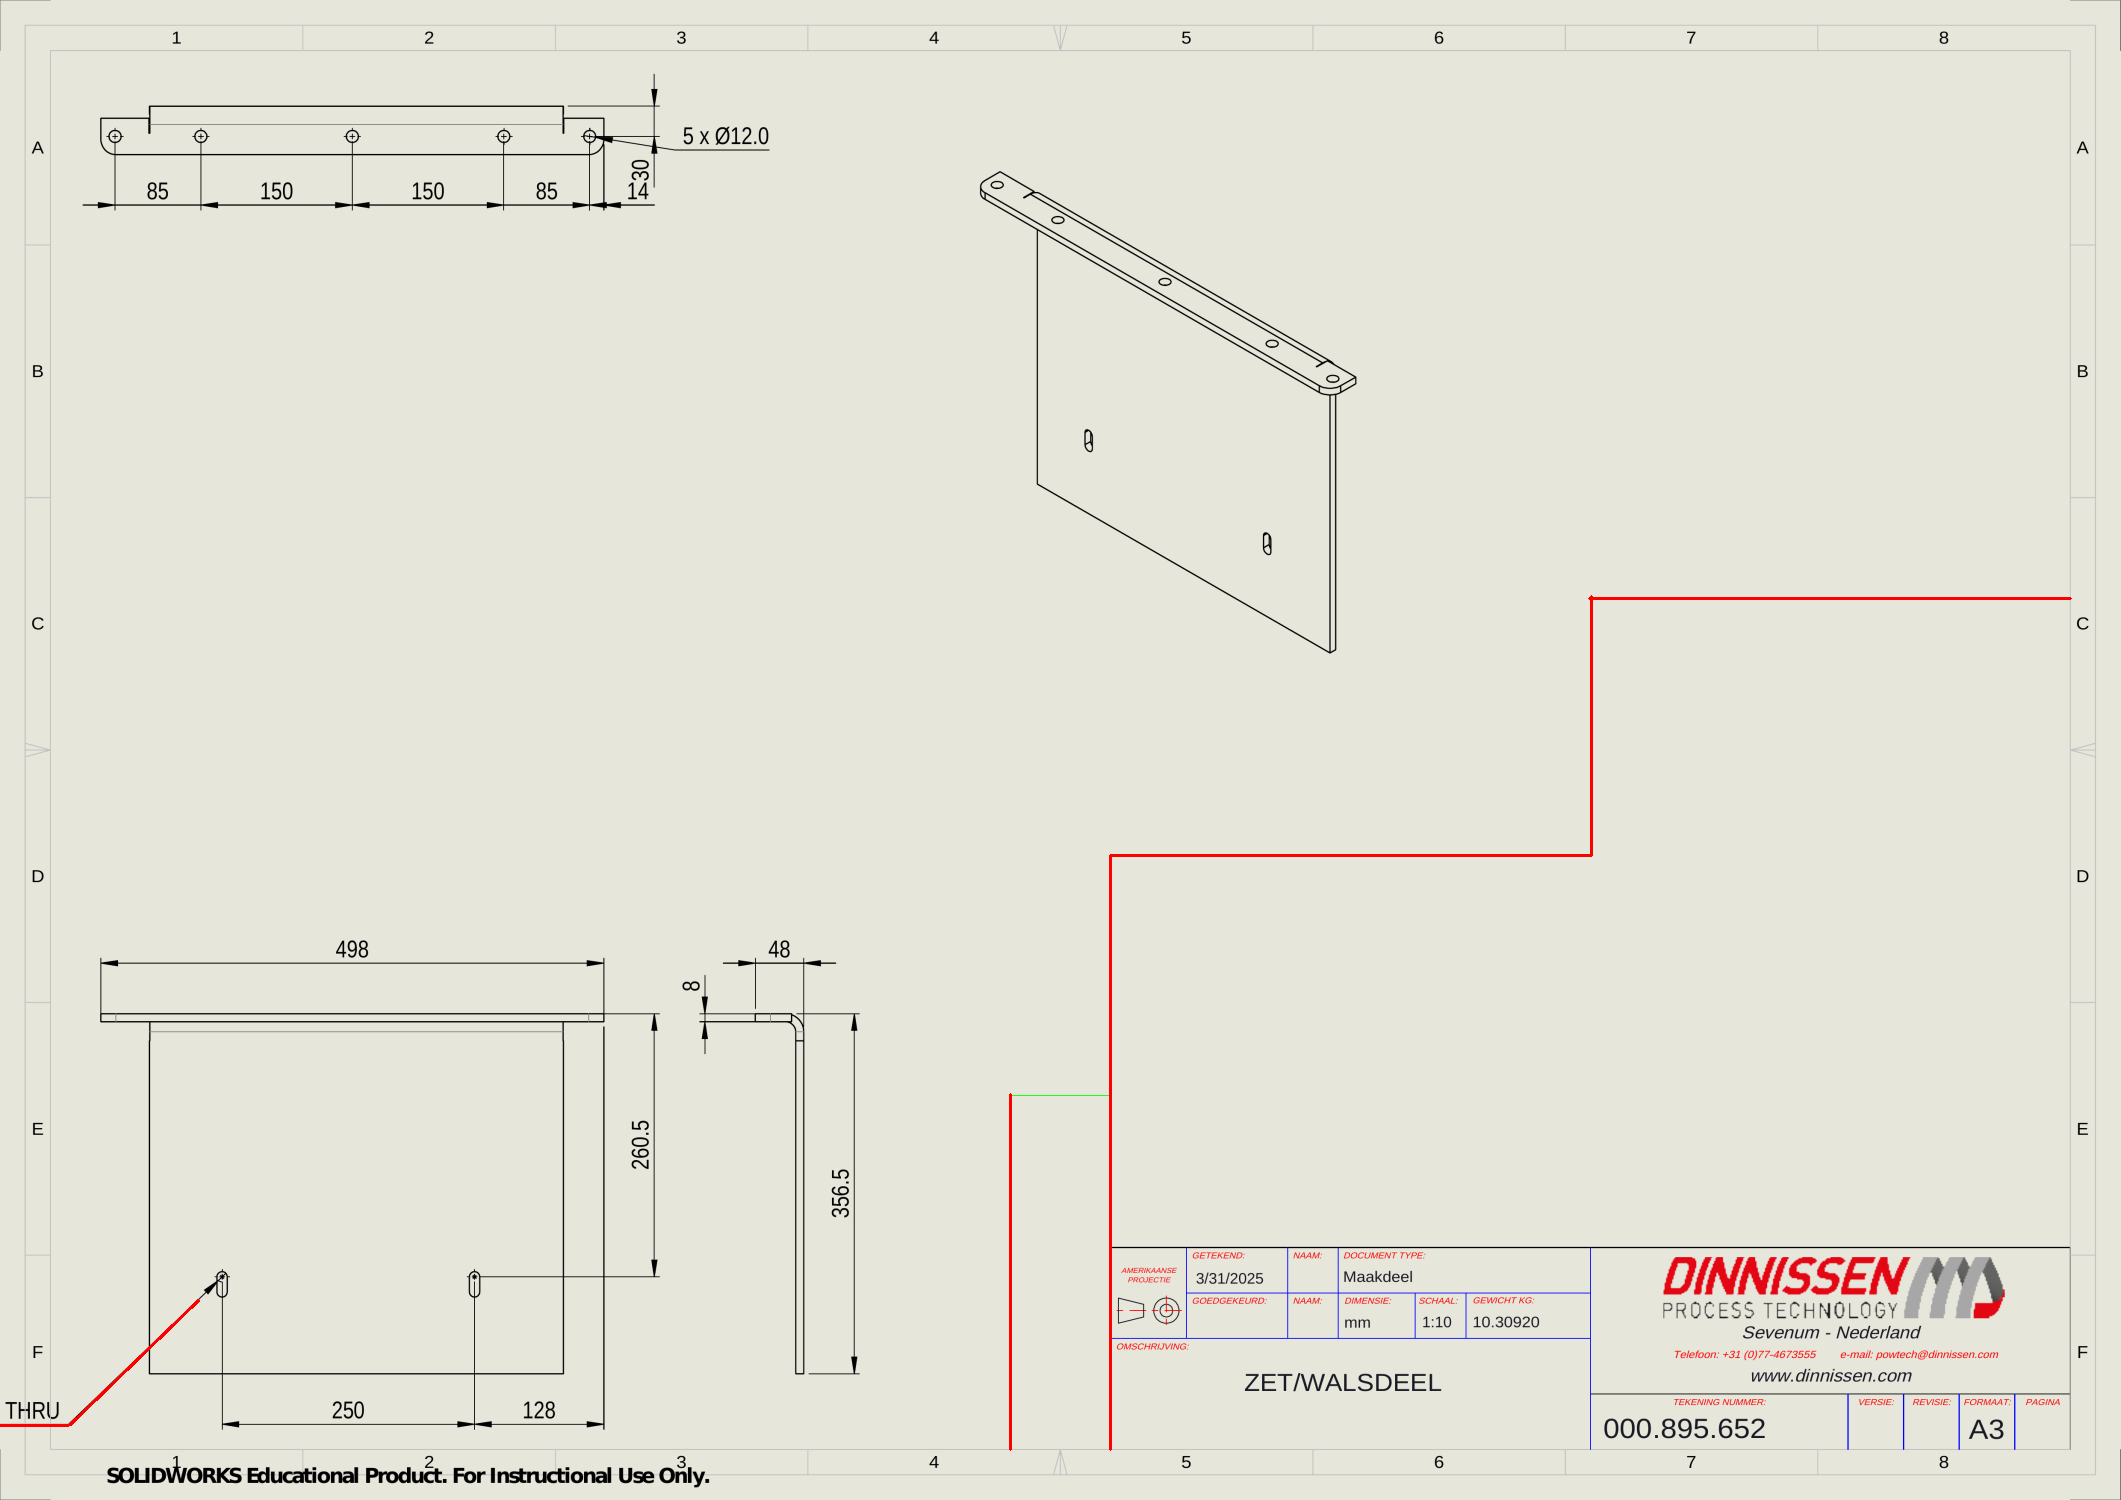

In [4]:
img_comp = img.copy()

for x1, y1, x2, y2 in intersected_extended_lines:
    cv2.line(img_comp, (x1, y1), (x2, y2), (255, 0, 0), 2)

Image.fromarray(img_comp)